In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf
from keras import regularizers

/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 21 # the number of joints
        self.joint_d = 3 # the dimension of joint
        self.joint_ind = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
        self.key_ind = np.array([1,3,7,11,14,18])
        self.feat_d = 126
        self.filters = 64
        self.clc_num=49
C = Config()

In [4]:
def norm_scale(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def get_CG_single(p,C):
    M = []
    for f in range(C.frame_l):
        #distance max 
        d_m = cdist(p[f][C.key_ind,:],p[f],'euclidean')
        d_m = d_m.flatten()
        M.append(d_m)   
    M = np.stack(M)  
    M = norm_scale(M)
    return M

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    #P_diff_slow = Lambda(lambda x: tf.norm(x,axis=-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    #P_diff_fast = Lambda(lambda x: tf.norm(x,axis=-1))(P_diff_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x

def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=21,joint_d=3,feat_d=210,filters=128):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = block(x,filters)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.05)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = block(x_d_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.05)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = block(x_d_fast,filters) 
    x_d_fast = SpatialDropout1D(0.05)(x_d_fast)
    
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.2)(x)
    
    x = block(x,filters*8)
    x = SpatialDropout1D(0.2)(x)

    return Model(inputs=[M,P],outputs=x)

In [6]:
def build_AR_single(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d))    
   
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])
    
    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,256)
    x = Dropout(0.5)(x)
    x = d1D(x,256)
    x = Dropout(0.5)(x)

    x = Dense(C.clc_num, activation='softmax')(x)
    
    return Model(inputs=[M,P],outputs=x)


In [7]:
AR_single = build_AR_single(C)
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 126)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 21, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1763072     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]                    
__________

In [8]:
AR_single.load_weights('weights/weight_xv_1D_single_aug.h5')

## Assign the data path

In [9]:
data_path = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/NTU/'
xlist = ['xview_train.pkl','xview_val.pkl','xsub_train.pkl','xsub_val.pkl']

## Cross view train

In [10]:
xv_train = pd.read_pickle(data_path+xlist[0],compression='gzip')

## Without frame_sampling

In [10]:
X_0 = []
X_1 = []
Y = []
num_xv_train = len(xv_train['label'])
for i in tqdm(range(num_xv_train)): 
    p_0 = xv_train['poses'][i][0][:,C.joint_ind,:]
    p_1 = xv_train['poses'][i][1][:,C.joint_ind,:]

    if np.all(p_0==0) or np.all(p_1==0): # only count single oject
        if np.all(p_0==0):
            p = np.copy(p_1)
        elif np.all(p_1==0):
            p = np.copy(p_0)
    else:
        continue 
        
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    try:
        label = np.zeros(49)
        label[xv_train['label'][i]-1] = 1   
    except:
        continue
        #print(xv_train['name'][i])

    M = get_CG_single(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  0%|          | 0/37646 [00:00<?, ?it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 37646/37646 [01:49<00:00, 344.60it/s]


In [13]:
import keras
lr = 2e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8, patience=5, cooldown=5, min_lr=1e-4)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=2048,
        epochs=300,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 29531 samples, validate on 14901 samples
Epoch 1/300
29531/29531 [==============================] - 11s 371us/step - loss: 3.5269 - acc: 0.1108 - val_loss: 3.3506 - val_acc: 0.1709
Epoch 2/300
29531/29531 [==============================] - 3s 96us/step - loss: 2.5680 - acc: 0.2691 - val_loss: 2.2894 - val_acc: 0.3391
Epoch 3/300
29531/29531 [==============================] - 3s 96us/step - loss: 2.0489 - acc: 0.3938 - val_loss: 2.1315 - val_acc: 0.4141
Epoch 4/300
29531/29531 [==============================] - 3s 94us/step - loss: 1.7587 - acc: 0.4650 - val_loss: 2.0498 - val_acc: 0.4514
Epoch 5/300
29531/29531 [==============================] - 3s 94us/step - loss: 1.5855 - acc: 0.5119 - val_loss: 2.3534 - val_acc: 0.4304
Epoch 6/300
29531/29531 [==============================] - 3s 95us/step - loss: 1.4514 - acc: 0.5513 - val_loss: 2.8111 - val_acc: 0.3629
Epoch 7/300
29531/29531 [==============================] - 3s 95us/step - loss: 1.3448 - acc: 0.5849 - val_loss: 2.3887 

Epoch 118/300
29531/29531 [==============================] - 3s 94us/step - loss: 0.0436 - acc: 0.9865 - val_loss: 0.7312 - val_acc: 0.8599
Epoch 119/300
29531/29531 [==============================] - 3s 96us/step - loss: 0.0414 - acc: 0.9870 - val_loss: 0.7245 - val_acc: 0.8646
Epoch 120/300
29531/29531 [==============================] - 3s 95us/step - loss: 0.0389 - acc: 0.9879 - val_loss: 0.9497 - val_acc: 0.8307
Epoch 121/300
29531/29531 [==============================] - 3s 96us/step - loss: 0.0417 - acc: 0.9863 - val_loss: 0.7769 - val_acc: 0.8583
Epoch 122/300
29531/29531 [==============================] - 3s 96us/step - loss: 0.0403 - acc: 0.9877 - val_loss: 0.7306 - val_acc: 0.8648
Epoch 123/300
29531/29531 [==============================] - 3s 96us/step - loss: 0.0380 - acc: 0.9878 - val_loss: 0.7907 - val_acc: 0.8541
Epoch 124/300
29531/29531 [==============================] - 3s 96us/step - loss: 0.0412 - acc: 0.9878 - val_loss: 0.7569 - val_acc: 0.8616
Epoch 125/300
29531/

29531/29531 [==============================] - 3s 88us/step - loss: 0.0061 - acc: 0.9984 - val_loss: 0.6901 - val_acc: 0.8946
Epoch 235/300
29531/29531 [==============================] - 3s 88us/step - loss: 0.0065 - acc: 0.9981 - val_loss: 0.6907 - val_acc: 0.8935
Epoch 236/300
29531/29531 [==============================] - 3s 91us/step - loss: 0.0056 - acc: 0.9982 - val_loss: 0.6902 - val_acc: 0.8932
Epoch 237/300
29531/29531 [==============================] - 3s 97us/step - loss: 0.0067 - acc: 0.9980 - val_loss: 0.6792 - val_acc: 0.8935
Epoch 238/300
29531/29531 [==============================] - 3s 92us/step - loss: 0.0068 - acc: 0.9982 - val_loss: 0.6781 - val_acc: 0.8940
Epoch 239/300
29531/29531 [==============================] - 3s 91us/step - loss: 0.0059 - acc: 0.9982 - val_loss: 0.6762 - val_acc: 0.8937
Epoch 240/300
29531/29531 [==============================] - 3s 93us/step - loss: 0.0063 - acc: 0.9984 - val_loss: 0.6807 - val_acc: 0.8924
Epoch 241/300
29531/29531 [=======

In [14]:
AR_single.save_weights('weights/weight_xv_1D_single.h5')

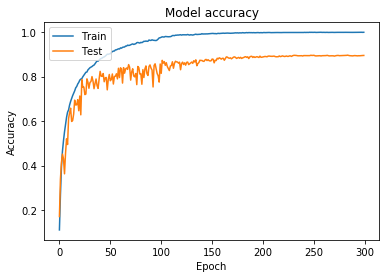

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## With frame_sampling

In [14]:
def sampling_frame_single(p,C):
    full_l = p.shape[0] # full length
    if random.uniform(0,1)<0.5: # aligment sampling
        valid_l = np.round(np.random.uniform(0.85,1)*full_l)
        s = random.randint(0, full_l-int(valid_l))
        e = s+valid_l # sample end point
        p = p[int(s):int(e),:,:]    
    else: # without aligment sampling
        valid_l = np.round(np.random.uniform(0.9,1)*full_l)
        index = np.sort(np.random.choice(range(0,full_l),int(valid_l),replace=False))
        p = p[index,:,:]
    p = zoom(p,C.frame_l,C.joint_n,C.joint_d)
    return p

In [15]:
lr = 5e-5
AR_single.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])

In [ ]:

epochs = 200
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    #for i in tqdm(range(len(xv_train['label']))): 
    for i in range(len(xv_train['label'])): 
        p_0 = xv_train['poses'][i][0][:,C.joint_ind,:]
        p_1 = xv_train['poses'][i][1][:,C.joint_ind,:]
        
        if np.all(p_0==0) or np.all(p_1==0): # only count single oject
            if np.all(p_0==0):
                p = np.copy(p_1)
            elif np.all(p_1==0):
                p = np.copy(p_0)
        else:
            continue 
            
        try:
            label = np.zeros(49)
            label[xv_train['label'][i]-1] = 1   
        except:
            continue

        p = sampling_frame_single(p,C)
           
        #rotation
        x_angle = np.random.uniform(-0.02,0.02)
        y_angle = np.random.uniform(-np.pi/2,np.pi/2)
        z_angle = np.random.uniform(-0.02,0.02)
        R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
        p = rotaion_one(p,R) 
       
        p = normlize_range(p)
 
        M = get_CG_single(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)

    AR_single.fit([X_0,X_1],Y,
            batch_size=2048,
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)
            )

    del X_0
    del X_1
    del Y
    gc.collect()

    if e%10==0:
        AR_single.save_weights('weights/weight_xv_1D_single_aug.h5')
    

epoch0


/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 8s 285us/step - loss: 0.1850 - acc: 0.9474 - val_loss: 0.4665 - val_acc: 0.9031
epoch1
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 107us/step - loss: 0.2028 - acc: 0.9453 - val_loss: 0.4650 - val_acc: 0.9028
epoch2
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 106us/step - loss: 0.1894 - acc: 0.9468 - val_loss: 0.4624 - val_acc: 0.9030
epoch3
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 108us/step - loss: 0.1846 - acc: 0.9479 - val_loss: 0.4611 - val_acc: 0.9030
epoch4
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 106us/step - loss: 0.1838 - acc: 0.9468 - val_loss: 0.4601 - val_acc: 0.9024
epoch5
Train on 29531 samples, valida

29531/29531 [==============================] - 3s 103us/step - loss: 0.1659 - acc: 0.9508 - val_loss: 0.4421 - val_acc: 0.9020
epoch43
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 108us/step - loss: 0.1757 - acc: 0.9499 - val_loss: 0.4396 - val_acc: 0.9023
epoch44
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 108us/step - loss: 0.1621 - acc: 0.9523 - val_loss: 0.4389 - val_acc: 0.9022
epoch45
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 108us/step - loss: 0.1660 - acc: 0.9527 - val_loss: 0.4387 - val_acc: 0.9024
epoch46
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [==============================] - 3s 107us/step - loss: 0.1684 - acc: 0.9501 - val_loss: 0.4393 - val_acc: 0.9026
epoch47
Train on 29531 samples, validate on 14901 samples
Epoch 1/1
29531/29531 [============

In [ ]:
AR_single.save_weights('weights/weight_xv_1D_single_aug.h5')

## Cross view validation

In [10]:
xv_val = pd.read_pickle(data_path+xlist[1],compression='gzip')

In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(xv_val['label']))):  

    p_0 = xv_val['poses'][i][0][:,C.joint_ind,:]
    p_1 = xv_val['poses'][i][1][:,C.joint_ind,:]

    if np.all(p_0==0) or np.all(p_1==0): # only count single oject
        if np.all(p_0==0):
            p = np.copy(p_1)
        elif np.all(p_1==0):
            p = np.copy(p_0)
    else:
        continue 

    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    try:
        label = np.zeros(49)
        label[xv_val['label'][i]-1] = 1   
    except:
        continue
        #print(xv_train['name'][i])

    M = get_CG_single(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

  0%|          | 76/18932 [00:00<00:48, 386.57it/s]/home/fan/anaconda3/envs/cv2/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 18932/18932 [00:53<00:00, 351.21it/s]


In [12]:
Y_pred = AR_single.predict([X_test_0,X_test_1])
acc = 1-np.count_nonzero(np.argmax(Y_pred,axis=1)-np.argmax(Y_test,axis=1))/Y_test.shape[0]
print('Accuracy:',acc)

Accuracy: 0.904637272666264


In [13]:
len(Y_test)

14901

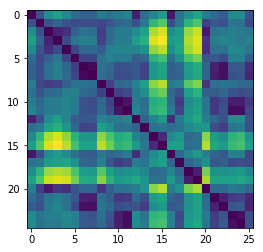

In [135]:
plt.imshow(M[30])
plt.show()

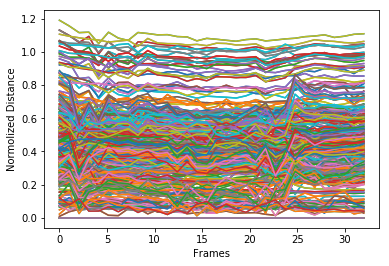

In [38]:
X = np.linspace(0,32,32, endpoint=True)

for i in range(25):
    for j in range(25):
        plt.plot(X,np.squeeze(M[:,i,j]))

plt.xlabel('Frames')
plt.ylabel('Euclidean Distance')

plt.show()